# Data exploration

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
data_dir = os.getenv('DATA_PATH')
data_dir

/Applications/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


'/Volumes/BERNHARDT/CLUST_Data'

In [2]:
listdir = [dI for dI in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,dI))]
current_dir = os.path.join(data_dir, listdir[0])
current_annotation_dir = os.path.join(current_dir, 'Annotation')
current_img_dir = os.path.join(current_dir, 'Data')
list_imgs = [os.path.join(current_img_dir, dI) for dI in os.listdir(current_img_dir) if (dI.endswith('png')\
                                                                                         and not dI.startswith('.'))]
list_features_files = [os.path.join(current_annotation_dir, dI) for dI \
                       in os.listdir(current_annotation_dir) if (dI.endswith('txt') \
                      and not dI.startswith('.'))]
list_imgs.sort()
list_features_files

['/Volumes/BERNHARDT/CLUST_Data/CIL-01/Annotation/CIL-01_1.txt',
 '/Volumes/BERNHARDT/CLUST_Data/CIL-01/Annotation/CIL-01_2.txt']

# Part I: playground

In [ ]:
%matplotlib inline
# Visualize images
# Image.open(x)
x = list_imgs[3]
n1, n2 = np.asarray(Image.open(x)).shape
plt.imshow(Image.open(x))
plt.grid(True)
plt.xticks(np.arange(0,n2,step=50))
plt.yticks(np.arange(0,n1,step=50))

In [ ]:
# Load labels
df = pd.read_csv(list_features_files[0], header=None, names=['id', 'x', 'y'], sep='\s+')
df.head()
df2 = pd.read_csv(list_features_files[1], header=None, names=['id', 'x', 'y'], sep='\s+')
df2['init'] = np.repeat(df2.x.values[0], len(df2))
df['init']=np.repeat(df.x.values[0], len(df))
print(list_features_files[1])
new = df.append(df2)
print(len(new))
new.head()

In [ ]:
# Visualize time series
from datetime import datetime, timedelta
df.dummy_date = df.id.map(lambda s: datetime.strptime('Jun 1 2005', '%b %d %Y') + timedelta(seconds=s))

plt.plot(df.dummy_date, df.x)

In [ ]:
plt.plot(df.id, df.y)

In [ ]:
# build ARIMA model
x = df.x.values
time = df.dummy_date.values.dtype

In [ ]:
from sklearn.metrics import mean_squared_error
df.index = df.dummy_date
model = ARIMA(df.x, order=(5,1,0))
model_fit = model.fit(disp=200)
print(model_fit.summary())

In [ ]:
X = df.x.values
size = int(len(X) * 0.66);
size = 60
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')

In [ ]:
Y = df.y.values
size = int(len(Y) * 0.66)
size = 60
train, test = Y[0:size], Y[size:len(Y)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')

In [ ]:
# use a window of 3
x = df.x.values
x_target = x[5:n]
n = len(x)
x_1 = np.append(np.nan, x[0:(n-1)])
x_2 = np.append([np.nan, np.nan], x[0:(n-2)])
x_3 = np.append([np.nan, np.nan, np.nan], x[0:(n-3)])
feats = np.vstack([x,x_1,x_2,x_3])
feats = np.transpose(feats)
feats = feats[4:(n-1)]
feats.shape
print(feats[0:4])
print(x_target[0:4])

In [ ]:
from sklearn.linear_model import RidgeCV
X = new.loc[:,['id', 'init']].values
print(X[1:10])
X_train, X_test, y_train, y_test = train_test_split(X, new.x.values.reshape(-1,1), test_size=0.33, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(feats, x_target, test_size=0.33, random_state=42)
# X_train2, X_test2, y_train2, y_test2 = train_test_split(new.id.values.reshape(-1,1), new.x.values.reshape(-1,1), test_size=0.33, random_state=42)

In [ ]:
est = RidgeCV()
X.shape
est.fit(X=X_train, y=y_train)
y_pred = est.predict(X_test)
np.mean((y_pred - y_test)**2)

In [ ]:
est = GradientBoostingRegressor(n_estimators=1000)
est.fit(X=X_train, y=y_train)
y_pred = est.predict(X_test)
np.mean((y_pred - y_test)**2)
plt.plot(y_pred)
plt.plot(y_test, 'red')

In [ ]:
est = RandomForestRegressor(n_estimators=1000)
est.fit(X=X_train, y=y_train)
y_pred = est.predict(X_test)
print(np.mean((y_pred - y_test)**2))
plt.plot(y_pred)
plt.plot(y_test, 'red')

# Part II: building the full dataset. Leave one out subject. 

In [ ]:
listdir = [dI for dI in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir,dI))]
current_dir = os.path.join(data_dir, listdir[0])
current_annotation_dir = os.path.join(current_dir, 'Annotation')
current_img_dir = os.path.join(current_dir, 'Data')
list_imgs = [os.path.join(current_img_dir, dI) for dI in os.listdir(current_img_dir) if dI.endswith('png')]
list_features_files = [os.path.join(current_annotation_dir, dI) for dI in os.listdir(current_annotation_dir) if dI.endswith('txt')]

k=0
df_test = pd.read_csv(list_features_files[k], header=None, names=['id', 'x', 'y'], sep='\s+')
df_test['init']= np.repeat(df_test.x.values[0], len(df_test))
df_test.head()

df_train = pd.DataFrame(columns = ['id', 'x', 'y', 'init'])
for dir in listdir[1:len(listdir)]:
    current_dir = os.path.join(data_dir, dir)
    current_annotation_dir = os.path.join(current_dir, 'Annotation')
    list_features_files = [os.path.join(current_annotation_dir, dI) for dI \
                           in os.listdir(current_annotation_dir) \
                           if (dI.endswith('txt') and not dI.startswith('.'))]

    for file in list_features_files:
        tmp = pd.read_csv(file, header=None, names=['id', 'x', 'y'], sep='\s+')
        tmp['init'] = np.repeat(tmp.x.values[0], len(tmp))
        df_train = df_train.append(tmp)
        print(len(df_train))

In [ ]:
X_train = df_train.loc[:,['id', 'init']].values
y_train = df_train['x'].values
X_test = df_test.loc[:,['id', 'init']].values
y_test = df_test.loc[:,'x'].values

In [ ]:
est = RidgeCV()
X.shape
est.fit(X=X_train, y=y_train)
y_pred = est.predict(X_test)
np.mean((y_pred - y_test)**2)

In [ ]:
est = RandomForestRegressor(n_estimators=1000)
est.fit(X=X_train, y=y_train)
y_pred = est.predict(X_test)
print(np.mean((y_pred - y_test)**2))
plt.plot(y_pred)
plt.plot(y_test, 'red')

# Part III: dealing with the images

In [3]:
## First trial https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5688953/
img1 = list_imgs[0]
img2 = list_imgs[1]
file1 = list_features_files[0]
df = pd.read_csv(list_features_files[0], header=None, names=['id', 'x', 'y'], sep='\s+')
df.head()

# Implement global matching search via NCC
    # 1. Define template of size [50,50] or less it depends
    # 2. Extract template of previous frame. 
    # 3. Calculate the search points. grid of 51x51 pixel around the previous center point.
    # 4. Look for the highest NCC, if NNC is above 0.55 accept this template.
    # 5. Else recalculate with good previous frame, if NCC above 0.55 accept this one.
    # 6. Else recalculate with init frame, if NCC above 0.55 accept.
    # 7.  if all three global searches have a maximum of less than the threshold, 
    # the maximum across all three is used to define the global shift. 
# Returns the template containing the features.
# Assess this part separately. 

# Implement local search. 
    # Random forest with intensity distribution of previous template (if good), of init frame/good previous template,
    # with previous position location or even ten last positions. 
    # Try to compare with their method.

,id,x,y
0,1.0,429.86027,199.19809
1,17.0,423.04417,198.20180
2,21.0,417.55687,196.64463
3,32.0,405.53780,197.02837
4,40.0,412.64353,195.86047


In [4]:
from matplotlib.patches import Rectangle
def plot_img_template(c1,c2,img, width=50, height=50):
    x = c1 - width/2
    y = c2 - height/2
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img, cmap='gray', vmin=0, vmax=255)
    ax.scatter(c1-1, c2-1, s=10)
    rect=Rectangle((x,y), width, height, fill=False)
    ax.add_patch(rect)
    plt.show()

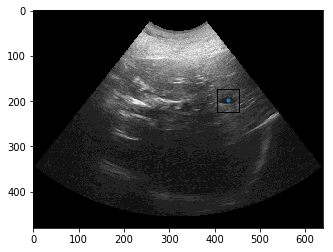

In [5]:
c1, c2 = df.loc[0, ['x', 'y']]
im1 = np.asarray(Image.open(img1)) 
im2 = np.asarray(Image.open(img2))
plot_img_template(c1,c2,im1, width=50, height=50)

In [6]:
# Find pixels around a given center
def find_search_pixel(c1, c2, width=100):
    xax = np.linspace(c1-width/2,c1+width/2,51,dtype='int')
    yax = np.linspace(c2-width/2,c2+width/2,51,dtype='int')
    #xax = np.arange(int(c1)-25, int(c1)+26, step=1)
    #yax = np.arange(int(c2)-25, int(c2)+26, step=1)
    return np.meshgrid(xax, yax) # all the x,y in the template centered around c1, c2

def find_template_pixel(c1, c2, width=100):
    w = width//2
    xax = np.arange(int(c1)-w, int(c1)+w+1, step=1)
    yax = np.arange(int(c2)-w, int(c2)+w+1, step=1)
    return np.meshgrid(xax, yax) # all the x,y in the template centered around c1, c2

429.86027 199.19808999999998


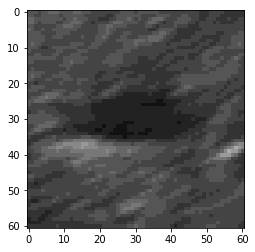

In [7]:
x, y = find_template_pixel(c1, c2, width=60)
print(c1,c2)
list(zip(np.ravel(y), np.ravel(x)))
img_array = np.asarray(Image.open(img1))
%matplotlib inline
plt.imshow(img_array[np.ravel(y), np.ravel(x)].reshape(61, 61), cmap='gray', vmin=0, vmax=255)

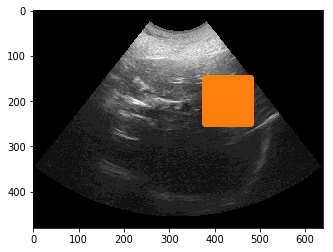

In [34]:
xv, yv = find_search_pixel(c1, c2)  
# Display the image
# Create figure and axes
fig,ax = plt.subplots(1)
ax.imshow(Image.open(img1))
ax.scatter(c1, c2, s=1)
ax.scatter(xv, yv)
plt.show()


In [8]:
def find_new_template_center_NCC(c1, c2, im1, im2, width=100, c1_init = None, c2_init=None):
    searchx, searchy = find_search_pixel(c1, c2)
    if c1_init is None:
        xv, yv = find_template_pixel(c1, c2, width) 
    else:
        xv, yv = find_template_pixel(c1_init, c2_init, width)
    NCC_all = []
    for i, j in zip(np.ravel(searchx), np.ravel(searchy)):
        #print(i,j)
        tmp_x, tmp_y = find_template_pixel(i, j, width)
        #fig, ax = plt.subplots(1)
        #ax.imshow(im2)
        #ax.scatter(tmp_x, tmp_y)
        #plt.show()
        print(np.min(np.ravel(tmp_x)))
        x1 = np.ravel(im1[np.ravel(yv), np.ravel(xv)])
        x2 = np.ravel(im2[np.ravel(tmp_y), np.ravel(tmp_x) ])
        x1 = x1 - np.mean(x1)
        x2 = x2 - np.mean(x2)
        num = np.sum(x1*x2)
        denom = np.sqrt(np.sum(x1**2)*np.sum(x2**2))
        NCC_all.append(num/denom)
    maxNCC = np.max(NCC_all)
    idx = np.argmax(NCC_all)
    best_c1, best_c2 = np.ravel(searchx)[idx], np.ravel(searchy)[idx]
    return best_c1, best_c2, maxNCC

(480, 640)
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
4

420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
previous center: 429.86027, 199.19808999999998
new center: 429, 199
maxNCC: 0.7789641903946276


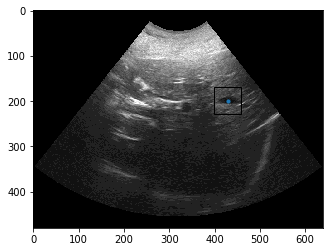

In [9]:
im2 = np.asarray(Image.open(list_imgs[2]))
print(im2.shape)
best_c1, best_c2, maxNCC = find_new_template_center_NCC(c1, c2, im1, im2, width=50)
print('previous center: {}, {}'.format(c1, c2))
print('new center: {}, {}'.format(best_c1, best_c2))
print('maxNCC: {}'.format(maxNCC))
plot_img_template(best_c1, best_c2, im2, width=60, height=60)

In [115]:
def global_template_search(c1,
                           c2,
                           c1_prev,
                           c2_prev,
                           c1_init,
                           c2_init,
                           im_prev,
                           im_current,
                           im_init,
                           im_prev_good,
                           threshold_good = 0.95,
                           threshold_bad = 0.75,
                          width=100):
    best_c1_1, best_c2_1, maxNCC_1 = find_new_template_center_NCC(c1, c2, 
                                                                  im_prev,
                                                                  im_current,
                                                                  width) 
    best_c1_3, best_c2_3, maxNCC_3 = find_new_template_center_NCC(c1, c2,
                                                              im_init,
                                                              im_current,
                                                             width,c1_init, c2_init)
    # Case very good match
    if maxNCC_1 > threshold_good: 
        im_prev_good = im_current # new good image to save
        return best_c1_1, best_c2_1, maxNCC_1, im_prev_good, best_c1_1, best_c2_1
    # Case bad match
    elif maxNCC_1 < threshold_bad: 
        best_c1_2, best_c2_2, maxNCC_2 = find_new_template_center_NCC(c1, c2,
                                                                      im_prev_good,
                                                                      im_current,
                                                                     width, c1_prev, c2_prev)
        # Case very bad match
        if maxNCC_2 < threshold_bad: 
            best_c1_3, best_c2_3, maxNCC_3 = find_new_template_center_NCC(c1, c2,
                                                                          im_init,
                                                                          im_current,
                                                                         width)
            # Case no good match
            if maxNCC_3 < threshold_bad:
                idx = np.argmax([maxNCC_1, maxNCC_2, maxNCC_3])
                best_c1 = [best_c1_1, best_c1_2, best_c1_3][idx]
                best_c2 = [best_c2_1, best_c2_2, best_c2_3][idx]
            else:
                print('3')
                return best_c1_3, best_c2_3, maxNCC_3, im_prev_good, c1_prev, c2_prev
                
        else:
            print('2')
            return best_c1_2, best_c2_2, maxNCC_2, im_prev_good, c1_prev, c2_prev  
    else:
        return best_c1_1, best_c2_1, maxNCC_1, im_prev_good, c1_prev, c2_prev     

In [116]:
w=70
c1_init, c2_init = df.loc[0, ['x', 'y']]
best_c1, best_c2, maxNCC, im_prev_good, c1_prev, c2_prev = global_template_search(c1, c2,
c1_init, c2_init, c1_init, c2_init, im1, im2, im1, im1, width=w)
print(best_c1, best_c2, maxNCC)
plot_img_template(best_c1, best_c2, im2, width=w, height=w)

429 199 0.7737743656166632


In [117]:
def predict_templates(list_imgs, df, T=len(list_imgs), width=100, threshold_bad=0.55):
    list_c1 = []
    list_c2 = []
    list_NCC = []
    img_init = np.asarray(Image.open(list_imgs[0]))
    img_current = img_init
    img_prev_good = img_init
    c1_init, c2_init = df.loc[0, ['x', 'y']]
    c1_prev, c2_prev = df.loc[0, ['x', 'y']]
    list_c1.append(c1_init)
    list_c2.append(c2_init)
    for t in range(1, T):
        img_previous = img_current
        img_current = np.asarray(Image.open(list_imgs[t]))
        #print(np.sum(np.abs(img_previous-img_current)))
        best_c1, best_c2, maxNCC, img_prev_good, c1_prev, c2_prev = global_template_search(list_c1[-1], 
                                                                        list_c2[-1], 
                                                                        c1_prev, c2_prev,
                                                                        c1_init, c2_init,                  
                                                                        img_previous, 
                                                                        img_current,
                                                                        img_init,
                                                                        img_prev_good,
                                                                        width=width,
                                                                        threshold_bad = threshold_bad)
        #plot_img_template(best_c1, best_c2, img_current, width=width, height=width)
        list_c1.append(best_c1)
        list_c2.append(best_c2)
        list_NCC.append(maxNCC)
        if t%10==0:
            print(best_c1, best_c2, maxNCC)
            print(t)
    return list_c1, list_c2, list_NCC

In [118]:
list_c1, list_c2, list_NCC = predict_templates(list_imgs, df, width=70)

431 199 0.9190039761310311
10
421 199 0.8142705001633914
20
415 199 0.8889692848603208
30
415 199 0.8738620209267279
40
425 199 0.8881154045351727
50
431 199 0.8734179076166139
60
431 199 0.8046996015193731
70
415 199 0.8835922752343688
80
405 199 0.9084049572354832
90
409 199 0.9140249878931427
100
419 199 0.8915723332368782
110
425 199 0.9310990731470038
120
423 199 0.8904984376003561
130
413 199 0.8689295584402188
140
407 199 0.8799545779729484
150
409 199 0.861317026925314
160
417 199 0.8927176321996784
170
425 199 0.8836569538472078
180
425 199 0.9058074465952398
190
419 199 0.8880358193239689
200
407 199 0.9155759767241447
210
407 199 0.893272861424094
220
419 199 0.9108458458422701
230
427 199 0.8846204922386298
240
435 199 0.9187268425149846
250
427 199 0.9061098192277578
260
415 199 0.9091840205013115
270
411 199 0.8955858387155291
280
417 199 0.8848613099047927
290
425 199 0.8993788478399447
300
431 199 0.8826012401564758
310
417 199 0.87733508547369
320
411 199 0.91852138440

In [33]:
i = 190
print(list_c1[i], list_c2[i])
plot_img_template(list_c1[i], list_c2[i], np.asarray(Image.open(list_imgs[i])))

423 196


In [36]:
list_c1, list_c2, list_NCC = predict_templates(list_imgs, df, width=60)
from sklearn.metrics import mean_squared_error
idx = df.id.values.astype(int)
print(idx[0:20])
x_true = df.x.values
x_pred = np.asarray(list_c1)[idx-1]
np.sum((x_pred > x_true+width/2) or (x_pred < x_true-width/2))
print(mean_squared_error(x_true, x_pred))
plt.plot((x_true-x_pred)**2)# Interesting to note that the global tracking seems to shift with time.

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
[  1  17  21  32  40  49  67  69  97 106 110 119 139 140 141 143 161 175
 176 189]
2305.0111107282773


In [84]:
%matplotlib
plt.plot((x_true-x_pred)**2)# Interesting to note that the global tracking seems to shift with time.
np.histogram(x_true-x_pred)
# width 60
#(array([ 6, 11, 21, 14, 14, 12, 14, 26, 15, 11]),
# array([-7.4622  ,  1.720897, 10.903994, 20.087091, 29.270188, 38.453285,
#        47.636382, 56.819479, 66.002576, 75.185673, 84.36877 ]))

Using matplotlib backend: TkAgg


(array([ 6, 11, 21, 14, 14, 12, 14, 26, 15, 11]),
 array([-7.4622  ,  1.720897, 10.903994, 20.087091, 29.270188, 38.453285,
        47.636382, 56.819479, 66.002576, 75.185673, 84.36877 ]))

In [85]:
list_c1, list_c2, list_NCC = predict_templates(list_imgs, df, width=30)
from sklearn.metrics import mean_squared_error
idx = df.id.values.astype(int)
x_true = df.x.values
x_pred = np.asarray(list_c1)[idx-1]
print(mean_squared_error(x_true, x_pred)) # 94.34317677362006 width = 100
plt.plot((x_true-x_pred)**2)# Interesting to note that the global tracking seems to shift with time.
np.histogram(x_true-x_pred)

431 199 0.9530755697655948
10
417 199 0.8947811090362673
20
409 199 0.9561739322144778
30
409 199 0.9282885184978505
40
413 199 0.9483464993144666
50
421 199 0.9132858675512454
60
421 199 0.8273528877950398
70
405 199 0.9365997728383094
80
393 199 0.9604418480835702
90
395 199 0.9568096909975679
100
407 199 0.9319015838472029
110
411 199 0.9469015436840893
120
409 199 0.8652644797600562
130
397 199 0.9315572316204304
140
391 199 0.8998903770685593
150
397 199 0.9122443012142908
160
405 199 0.939494878482677
170
413 199 0.8773205042243554
180
419 199 0.8738423304859758
190
409 199 0.9043145859914495
200
395 199 0.9560099119382791
210
393 199 0.9287434296217689
220
401 199 0.9544649238486447
230
407 199 0.9248736429610935
240
415 199 0.8986780717041775
250
407 199 0.9300086317620665
260
393 199 0.939917282943089
270
393 199 0.9368479358991794
280
399 199 0.9367108467968314
290
405 199 0.9144421921840065
300
411 199 0.8061804804098237
310
397 199 0.928335582920631
320
391 199 0.9197979023

(array([ 4,  5, 16, 24, 33, 20, 16, 11,  9,  6]),
 array([-3.4622  ,  1.816527,  7.095254, 12.373981, 17.652708, 22.931435,
        28.210162, 33.488889, 38.767616, 44.046343, 49.32507 ]))

In [86]:
list_c1, list_c2, list_NCC = predict_templates(list_imgs, df, width=100)
from sklearn.metrics import mean_squared_error
idx = df.id.values.astype(int)
print(idx)
x_true = df.x.values
x_pred = np.asarray(list_c1)[idx-1]
print(mean_squared_error(x_true, x_pred))
plt.plot((x_true-x_pred)**2)# Interesting to note that the global tracking seems to shift with time.
np.histogram(x_true-x_pred)

431 199 0.9255032794936427
10
421 199 0.8456531248695851
20
415 199 0.886937862104982
30
415 199 0.8860124232741031
40
425 199 0.8899567855190375
50
429 199 0.8980839786714451
60
429 199 0.8665438153424663
70
413 199 0.8952643055526684
80
405 199 0.9055928387170187
90
409 199 0.9052313405446515
100
415 199 0.8974326376880934
110
421 199 0.935869414209826
120
419 199 0.9072978482116605
130
409 199 0.885652049791516
140
403 199 0.8941257348376516
150
403 199 0.8888318344631058
160
411 199 0.9075930272562838
170
419 199 0.9063814983943227
180
419 199 0.931576795618894
190
413 199 0.9035349291895881
200
401 199 0.9167098529967088
210
401 199 0.9074587720558406
220
411 199 0.9115392730409964
230
417 199 0.9061543713936061
240
421 199 0.9336184223764954
250
413 199 0.9210622132028153
260
401 199 0.9158961810202045
270
397 199 0.9032868663533334
280
403 199 0.9045095743425703
290
411 199 0.916244839588435
300
417 199 0.9151571153136077
310
405 199 0.898599066613433
320
399 199 0.9251738848168

KeyboardInterrupt: 

In [35]:
%matplotlib
plt.plot(np.asarray(list_NCC)[idx-1])

Using matplotlib backend: TkAgg


In [ ]:
## 
# Build a "feature detection" network
# feed the initial box, the current frame as an input and try to predict the center of the object. 

# could also divide in a grid and compute the correlation of each box with the initial box containing the center. 


# could also do the predictions in a row and limit to a big box around the previous prediction or around the 
# predicted value from the time series.

# or just feed location 1, image 1, image 2 and predict location 1 in image 2. 
#img_init = np.asarray(Image.open(list_imgs[0]))
#c1, c2 = df.x.values[0], df.y.values[0]
#template_init = find_template_pixel(c1, c2, width=60)
w = 60
feats_intensity = []
img_init = np.asarray(Image.open(list_imgs[0]))
print(np.max(img_init))
c1_init, c2_init = df.loc[df['id']==1, ['x', 'y']].values[0,:]
xax, yax = find_template_pixel(c1, c2, width=w)
img_template = img_init[np.ravel(yax), np.ravel(xax)]
feats_init = np.histogram(img_template, bins=20, range=(0,255))
for i in df.id.values[0:5]:
    print(i)
    print(list_imgs[int(i)-1])
    img = np.asarray(Image.open(list_imgs[int(i)-1]))
    #print(img.size)
    c1, c2 = df.loc[df['id']==i, ['x', 'y']].values[0,:]
    #print(c1, c2)
    xax, yax = find_template_pixel(c1, c2, width=w)
    img_template = img[np.ravel(yax), np.ravel(xax)]
    tmp = np.histogram(img_template, bins=20, range=(0,255))
    feats_intensity.append(feats_intensity)
feats_intensity = np.reshape(feats_intensity,(-1, 20))
x_coords_init = np.repeat(df.x.values[0], len(list_imgs))
y_coords_init = np.repeat(df.y.values[0], len(list_imgs))

X_full = np.vstack(feats_intensity, x_coords_init, y_coords_init)
y_y = df.y.values
y_x = df.x.values
X_full.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_x.reshape(-1,1), test_size=0.33, random_state=42)

In [ ]:
est = RandomForestRegressor(n_estimators=1000)
est.fit(X=X_train, y=y_train)
y_pred = est.predict(X_test)
print(np.mean((y_pred - y_test)**2))
plt.plot(y_pred)
plt.plot(y_test, 'red')

In [39]:
# get the training set
# train the algorithm (it's independent of block matching.)
# then predict global shift, predict center with regressor and go on. 

array([ 0,  6, 13, 20])